# ****Importing Important Libraries****

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# 1-Preprocessing

In [60]:
df=pd.read_csv('abe.us.txt')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3190 entries, 0 to 3189
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3190 non-null   object 
 1   Open     3190 non-null   float64
 2   High     3190 non-null   float64
 3   Low      3190 non-null   float64
 4   Close    3190 non-null   float64
 5   Volume   3190 non-null   int64  
 6   OpenInt  3190 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 174.6+ KB


In [62]:
df.Date = pd.to_datetime(df.Date)

In [63]:
df.isna().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [64]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.0
mean,11.599416,11.712848,11.484610,11.605599,28444.870846,0.0
std,2.350376,2.365621,2.327065,2.341989,37525.175821,0.0
min,5.860300,5.905000,5.834700,5.841100,106.000000,0.0
25%,10.534000,10.655000,10.413750,10.554000,8147.750000,0.0
50%,11.981000,12.067000,11.899000,11.988500,17741.500000,0.0
75%,13.271000,13.386750,13.189000,13.295750,36167.250000,0.0
max,18.130000,19.151000,17.842000,17.925000,634041.000000,0.0


As seen above, OpenInt is redundant, so it is removed.

In [65]:
df.drop(columns=['OpenInt'],inplace=True)

In [66]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387


## Ploting Close Price Historic Data

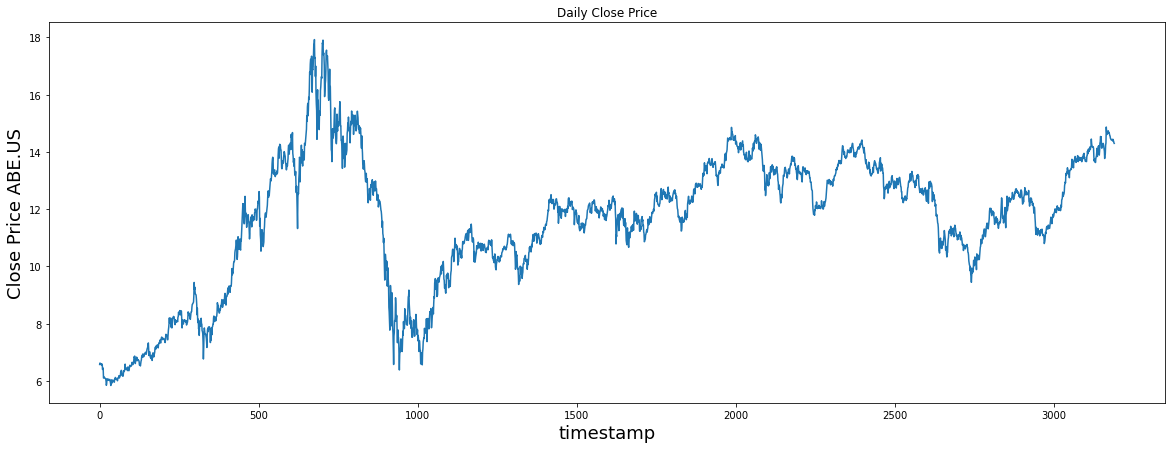

In [67]:
import seaborn as sns
plt.figure(figsize=(20,7))
plt.title('Daily Close Price')
plt.plot(df['Close'])
plt.xlabel('timestamp',fontsize=18)
plt.ylabel('Close Price ABE.US',fontsize=18)
plt.show()

In [68]:
data = df.loc[:,['Close']]
dataset = data.values

In [69]:
scaler = RobustScaler() #Robust scaling is apllied to all data for normalization.
scaled_data_rb = scaler.fit_transform(dataset)

# 2-Modeling

In [70]:
training_data_len = int(round(len(dataset)*0.8,0)) # 0.8 of all data is assigned for training, remains are planned to use in evaluation.
test_data_len = len(dataset) - training_data_len

In [71]:
training_data_len #total row number of training data

2552

In [72]:
dataset.shape

(3190, 1)

In [73]:
train_data = scaled_data_rb[0:training_data_len  , : ]
x_train=[]
y_train = []
for i in range(90,training_data_len):
    x_train.append(train_data[i-90:i,0])
    y_train.append(train_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [74]:
model = Sequential()
model.add(LSTM(units=60, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=60, return_sequences=False))
model.add(Dense(units=20))
model.add(Dense(units=1))

In [75]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [76]:
model.fit(x_train, y_train, batch_size=64, epochs=1)

39/39 [==============================] - 4s 54ms/step - loss: 0.1006


# 3-Evalutaion

In [77]:
test_data = scaled_data_rb[training_data_len - 90:] #Create the X_test,y_test data for evaluation
x_test = []
y_test =  dataset[training_data_len :]
for i in range(90,len(test_data)):
    x_test.append(test_data[i-90:i])

In [78]:
len(y_test)

638

In [79]:
predictions = model.predict(np.array(x_test)) 
predictions = scaler.inverse_transform(predictions)

20/20 [==============================] - 1s 12ms/step


In [80]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

0.27883803932491613

# Final Visualiation

C:\Users\dogucan.elci\AppData\Local\Temp\ipykernel_10752\4084537896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display['Predictions'] = predictions #Visualize the data


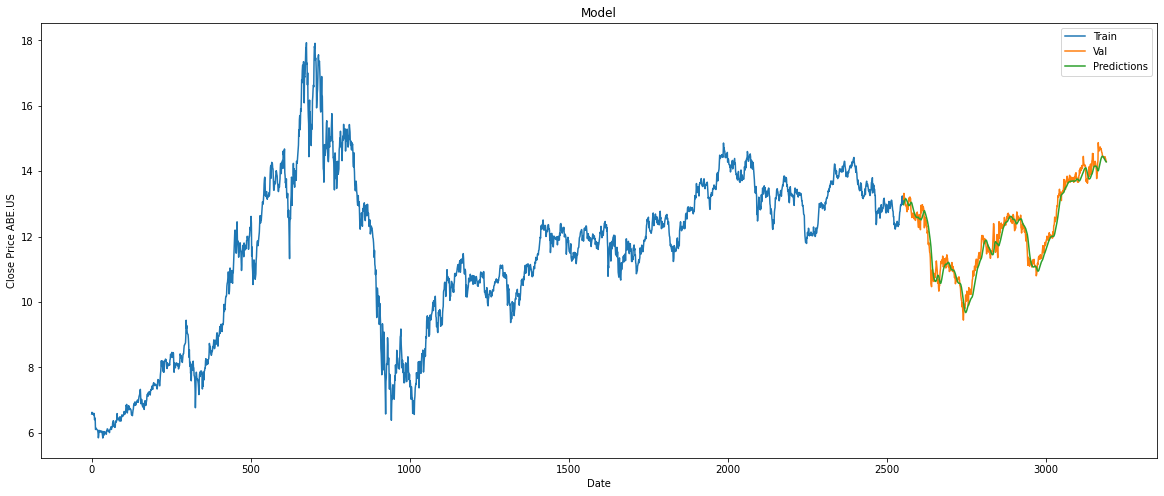

In [81]:
train = data[:training_data_len]
display = data[training_data_len:training_data_len + len(y_test)]
display['Predictions'] = predictions #Visualize the data
plt.figure(figsize=(20,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price ABE.US')
plt.plot(train['Close'])
plt.plot(display['Close'])
plt.plot(display['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()